# Principal Component Analysis

In [759]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
iris_df = pd.DataFrame(X, columns=iris.feature_names)
iris_df['target'] = y
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Describing the data
The Iris Dataset contains four features (length and width of sepals and petals) of 50 samples of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). These measures were used to create a linear discriminant model to classify the species. The dataset is often used in data mining, classification and clustering examples and to test algorithms.

In [760]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [761]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [762]:
iris_df.target.unique()

array([0, 1, 2])

As we see, our dataset has 150 records. There are not null values. In the target column, we got 3 values, depending on the species of the flower. We will use PCA to predict based on these features what type of iris is that.

# Plotting
## Correlation

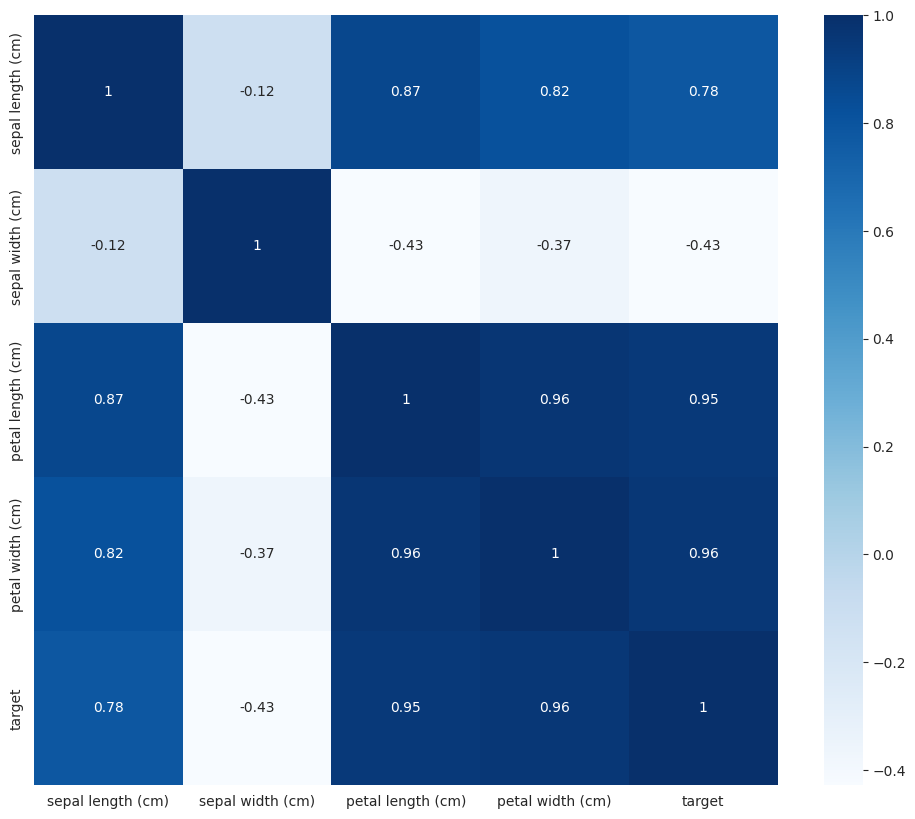

In [763]:
import seaborn as sns
plt.figure(figsize=(12,10))
cor = iris_df.corr(numeric_only=False)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()

As we see: petal width and petal length have the highest correlation of all features.

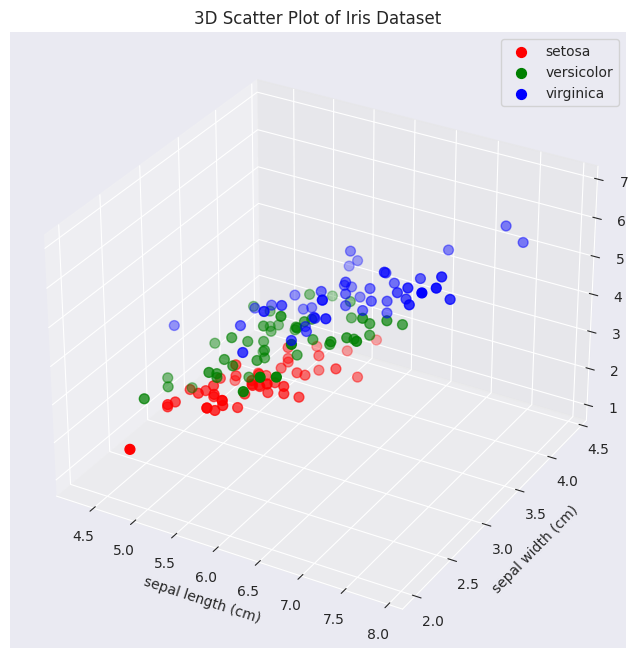

In [764]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b']
for target, color in zip(range(len(iris.target_names)), colors):
    indices = iris_df['target'] == target
    ax.scatter(iris_df.loc[indices, iris.feature_names[0]],
               iris_df.loc[indices, iris.feature_names[1]],
               iris_df.loc[indices, iris.feature_names[2]],
               c=color,
               s=50,
               label=iris.target_names[target])

ax.set_xlabel(iris.feature_names[0])
ax.set_ylabel(iris.feature_names[1])
ax.set_zlabel(iris.feature_names[2])

plt.title('3D Scatter Plot of Iris Dataset')
plt.legend()
plt.show()


# Transforming the data
## Handbook algorithm

In [765]:
class myPCA:
    def __init__(self, n_components: int = 2, method: str = 'svd') -> None:
        '''
        The constructor of the PCA algorithm.
        
        :param n_components: int, default = 2
            The dimension to which the data will be reduced.
        :param method: str, default = 'svd'
            The method used by PCA to reduce the dimensionality of the data.
        '''
        self.__n_components = n_components
        if method in ['svd', 'eigen']:
            self.__method = method
        else:
            raise ValueError(f"'{method}' is not a method implemented in this model")

    def fit(self, X: np.array):
        '''
        The fitting method.
        
        :param X: np.array
            The data on which we want to fit the PCA
        '''
        if self.__method == 'svd':
            U, S, V = np.linalg.svd(X)
            self.__V = V[:self.__n_components, :]
        elif self.__method == 'eigen':
            corr_mat = np.corrcoef(X.T)
            # Getting the eigenvectors and eigenvalues
            self.eig_vals, self.eig_vecs = np.linalg.eig(corr_mat)
            # Sorting the list of tuples (eigenvalue, eigenvector)
            self.eig_pairs = [(np.abs(self.eig_vals[i]), self.eig_vecs[:, i]) for i in range(len(self.eig_vals))]
            self.eig_pairs.sort(key=lambda x: x[0], reverse=True)
            # Calculating the explained ratio
            total = sum(self.eig_vals)
            self.explained_variance_ratio = [(i / total) * 100 for i in sorted(self.eig_vals, reverse=True)]
            self.cumulative_variance_ratio = np.cumsum(self.explained_variance_ratio)
            # Creating the projection matrix
            self.matrix_w = np.hstack(
                [self.eig_pairs[i][1].reshape(np.size(X, 1), 1) for i in range(self.__n_components)])
        return self

    def transform(self, X: np.array) -> np.array:
        '''
        The transform function.
        
        :param X: np.array
            The data that we must reduce.
        '''
        if self.__method == 'svd':
            return X.dot(self.__V.T)
        elif self.__method == 'eigen':
            return X.dot(self.matrix_w)

# Eigen alogirthm

In [766]:
mypca_eigen = myPCA(method='eigen')
mypca_eigen.fit(np.array(X))
X_eigen = mypca_eigen.transform(X)

# SVD algorithm

In [767]:
mypca_svd = myPCA(method='svd')
mypca_svd.fit(X)
X_svd = mypca_svd.transform(X)
X_svd

array([[-5.91274714e+00,  2.30203322e+00],
       [-5.57248242e+00,  1.97182599e+00],
       [-5.44697714e+00,  2.09520636e+00],
       [-5.43645948e+00,  1.87038151e+00],
       [-5.87564494e+00,  2.32829018e+00],
       [-6.47759822e+00,  2.32464996e+00],
       [-5.51597520e+00,  2.07090423e+00],
       [-5.85092859e+00,  2.14807482e+00],
       [-5.15891972e+00,  1.77506408e+00],
       [-5.64500117e+00,  1.99000106e+00],
       [-6.26539771e+00,  2.42576813e+00],
       [-5.75200785e+00,  2.02037338e+00],
       [-5.48058085e+00,  1.97777558e+00],
       [-4.95112411e+00,  2.04828749e+00],
       [-6.52596417e+00,  2.91606081e+00],
       [-6.79037199e+00,  2.82500759e+00],
       [-6.27239468e+00,  2.60811578e+00],
       [-5.92953789e+00,  2.26766614e+00],
       [-6.64813130e+00,  2.38959506e+00],
       [-6.09486463e+00,  2.36082303e+00],
       [-6.25397363e+00,  2.12001187e+00],
       [-6.07364677e+00,  2.27178150e+00],
       [-5.36999813e+00,  2.49808604e+00],
       [-6.


# SKlearn algorithm

In [768]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
X_skl = pca.transform(X)
X_skl

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

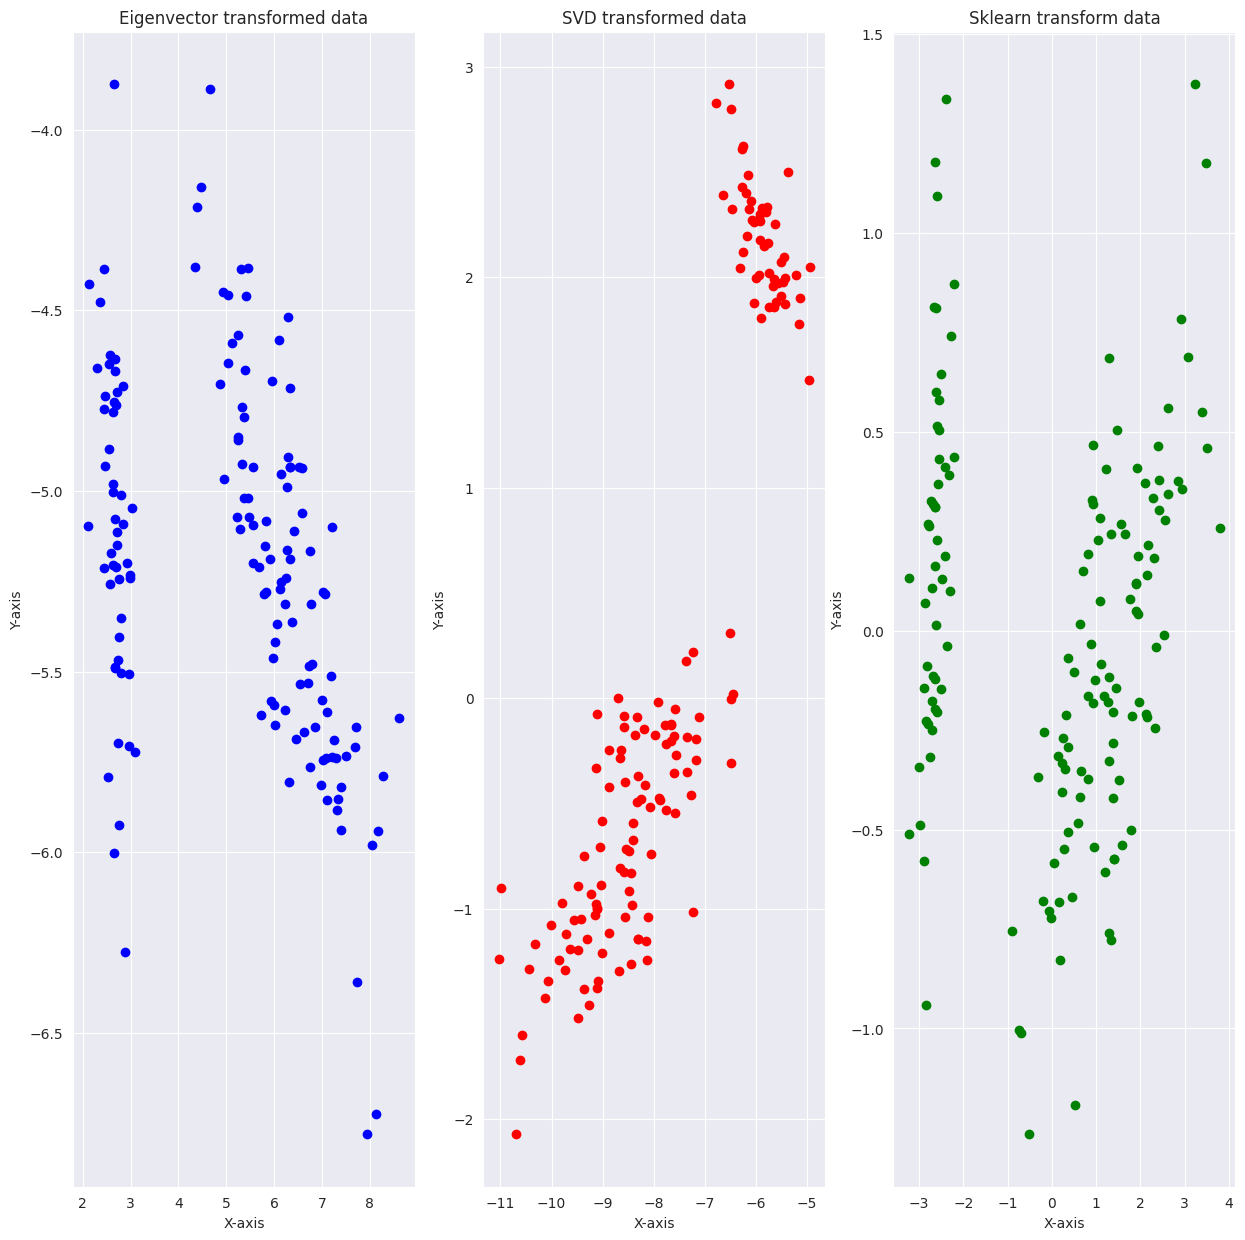

In [769]:
# Creating the plot
plt.figure(figsize=(15, 15))

plt.subplot(1, 3, 1)
plt.scatter(X_eigen[:, 0], X_eigen[:, 1], color='blue')
plt.title('Eigenvector transformed data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.subplot(1, 3, 2)
plt.scatter(X_svd[:, 0], X_svd[:, 1], color='red')
plt.title('SVD transformed data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

plt.subplot(1, 3, 3)
plt.scatter(X_skl[:, 0], X_skl[:, 1], color='green')
plt.title('Sklearn transform data')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display all plots
plt.show()

As we see every algorithm, has different results. The SVD algorithm, has a gap values while Eigen and Sklearn algorithm more or less has uniform data across Y axis. 

# Running pca with 1 component

In [770]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
X_pca

array([[-2.68412563],
       [-2.71414169],
       [-2.88899057],
       [-2.74534286],
       [-2.72871654],
       [-2.28085963],
       [-2.82053775],
       [-2.62614497],
       [-2.88638273],
       [-2.6727558 ],
       [-2.50694709],
       [-2.61275523],
       [-2.78610927],
       [-3.22380374],
       [-2.64475039],
       [-2.38603903],
       [-2.62352788],
       [-2.64829671],
       [-2.19982032],
       [-2.5879864 ],
       [-2.31025622],
       [-2.54370523],
       [-3.21593942],
       [-2.30273318],
       [-2.35575405],
       [-2.50666891],
       [-2.46882007],
       [-2.56231991],
       [-2.63953472],
       [-2.63198939],
       [-2.58739848],
       [-2.4099325 ],
       [-2.64886233],
       [-2.59873675],
       [-2.63692688],
       [-2.86624165],
       [-2.62523805],
       [-2.80068412],
       [-2.98050204],
       [-2.59000631],
       [-2.77010243],
       [-2.84936871],
       [-2.99740655],
       [-2.40561449],
       [-2.20948924],
       [-2

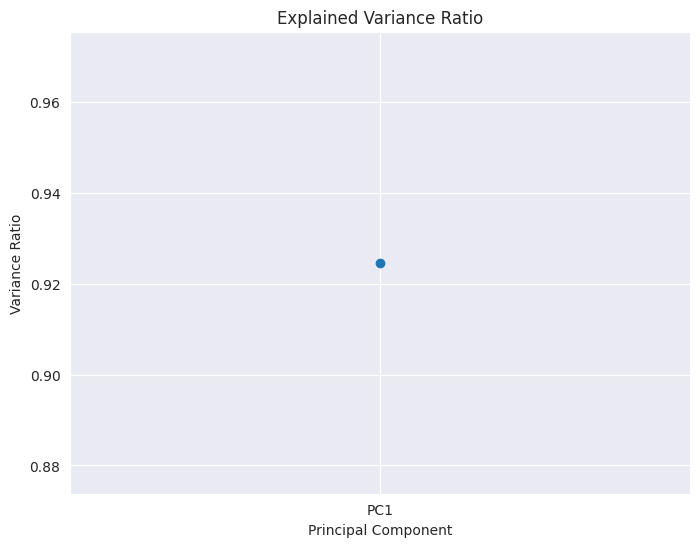

In [771]:
import matplotlib.pyplot as plt

# Plotting the explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(pca.explained_variance_ratio_, marker='o', linestyle='--')
plt.title('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.xticks(range(len(pca.explained_variance_ratio_)), [f'PC{i + 1}' for i in range(len(pca.explained_variance_ratio_))])
plt.grid(True)
plt.show()


Since the number of components is 1, it is clearly why the plot is just a dot, since it is one dimmensional.

# Subtask 2

## Loading dataset

In [772]:
from sklearn.datasets import load_digits

digits = load_digits()
X = digits.data
y = digits.target
df = pd.DataFrame(X, columns=digits.feature_names)
df['target'] = y

# Describing the dataset
This dataset is made up of 1797 8x8 images. Each image, like the one shown below, is of a hand-written digit. In order to utilize an 8x8 figure like this, we’d have to first transform it into a feature vector with length 64.

In [773]:
df.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [774]:
df.describe()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_1_0,pixel_1_1,...,pixel_6_7,pixel_7_0,pixel_7_1,pixel_7_2,pixel_7_3,pixel_7_4,pixel_7_5,pixel_7_6,pixel_7_7,target
count,1797.0,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,...,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000,1797.000000
mean,0.0,0.303840,5.204786,11.835838,11.848080,5.781859,1.362270,0.129661,0.005565,1.993879,...,0.206455,0.000556,0.279354,5.557596,12.089037,11.809126,6.764051,2.067891,0.364496,4.490818
std,0.0,0.907192,4.754826,4.248842,4.287388,5.666418,3.325775,1.037383,0.094222,3.196160,...,0.984401,0.023590,0.934302,5.103019,4.374694,4.933947,5.900623,4.090548,1.860122,2.865304
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.000000,1.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,11.000000,10.000000,0.000000,0.000000,0.000000,2.000000
50%,0.0,0.000000,4.000000,13.000000,13.000000,4.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,4.000000,13.000000,14.000000,6.000000,0.000000,0.000000,4.000000
75%,0.0,0.000000,9.000000,15.000000,15.000000,11.000000,0.000000,0.000000,0.000000,3.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,12.000000,2.000000,0.000000,7.000000
max,0.0,8.000000,16.000000,16.000000,16.000000,16.000000,16.000000,15.000000,2.000000,16.000000,...,13.000000,1.000000,9.000000,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000,9.000000


In [775]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1797 entries, 0 to 1796
Data columns (total 65 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pixel_0_0  1797 non-null   float64
 1   pixel_0_1  1797 non-null   float64
 2   pixel_0_2  1797 non-null   float64
 3   pixel_0_3  1797 non-null   float64
 4   pixel_0_4  1797 non-null   float64
 5   pixel_0_5  1797 non-null   float64
 6   pixel_0_6  1797 non-null   float64
 7   pixel_0_7  1797 non-null   float64
 8   pixel_1_0  1797 non-null   float64
 9   pixel_1_1  1797 non-null   float64
 10  pixel_1_2  1797 non-null   float64
 11  pixel_1_3  1797 non-null   float64
 12  pixel_1_4  1797 non-null   float64
 13  pixel_1_5  1797 non-null   float64
 14  pixel_1_6  1797 non-null   float64
 15  pixel_1_7  1797 non-null   float64
 16  pixel_2_0  1797 non-null   float64
 17  pixel_2_1  1797 non-null   float64
 18  pixel_2_2  1797 non-null   float64
 19  pixel_2_3  1797 non-null   float64
 20  pixel_2_

Dataset represents a grid of pixels with the intensity of the pixel as float number and the target is the number which this image represents.

## Plot 10 Random Digits in a 2x5 Grid

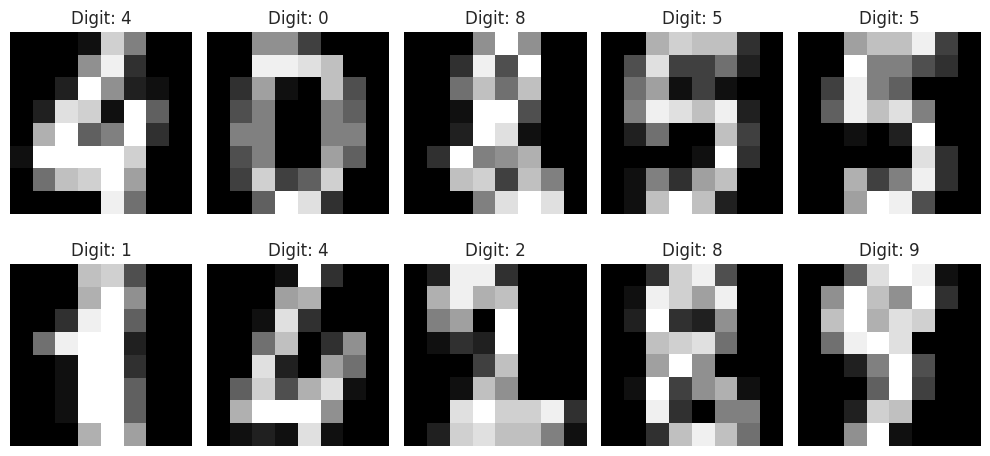

In [776]:
import matplotlib.pyplot as plt
import numpy as np

random_indices = np.random.choice(len(X), 10, replace=False)

fig, axes = plt.subplots(2, 5, figsize=(10, 5))

for i, ax in enumerate(axes.ravel()):
    digit_index = random_indices[i]
    image = digits.images[digit_index]
    label = digits.target[digit_index]

    ax.imshow(image, cmap='gray')
    ax.set_title(f'Digit: {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Create an Instance of the sklearn PCA

In [777]:
pca = PCA(n_components=2)


## Apply scalling

In [778]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Train and Transform

In [779]:
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)


## Create the plot

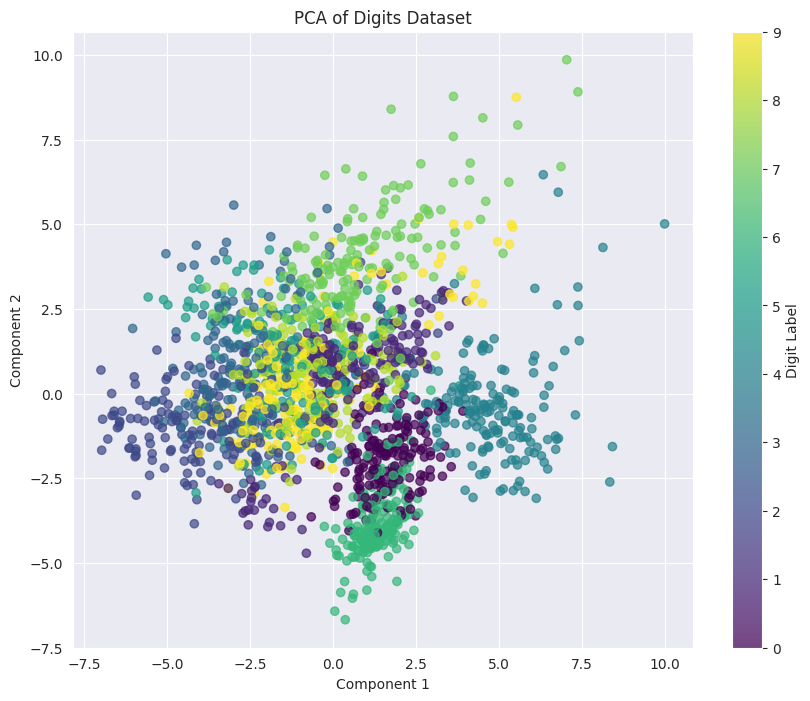

In [780]:
plt.figure(figsize=(10, 8))

# Scatter plot with colors according to digit labels
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7)

# Create a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Digit Label')

plt.title('PCA of Digits Dataset')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()
